# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

# Revisão de código 

Olá! 

Meu nome é Suelen. Estou feliz em revisar seu projeto hoje!

Quando vejo um erro pela primeira vez, apenas aponto. Deixarei você encontrá-lo e corrigi-lo sozinho. Além disso, ao longo do texto, farei algumas observações sobre melhorias no código e também farei comentários sobre suas percepções sobre o assunto. Mas se você ainda não consegue lidar com essa tarefa, darei uma dica mais precisa na próxima iteração e também alguns exemplos práticos. Estarei aberto a feedbacks e discussões sobre o tema.

Você pode encontrar meus comentários em caixas verdes, amarelas ou vermelhas como estas:


<div class="alert alert-block alert-success">
<b>Comentário: </b> <a class="tocSkip"></a>

Sucesso. Tudo está correto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário: </b> <a class="tocSkip"></a>

Observações. Algumas recomendações.
</div>

<div class="alert alert-block alert-danger">

<b>Comentário: </b> <a class="tocSkip"></a>

O bloco requer algumas correções. O trabalho não pode ser aceito com os comentários vermelhos.
</div>

Você pode me responder usando isto:

<div class="alert alert-block alert-info">
<b>Resposta do aluno</b> <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-success">
<b>Comentário geral: </b> <a class="tocSkip"></a>
    
Parabéns pela conclusão do projeto, Luiz! 🎉 Seu projeto está aprovado! Como pontos positivos, destaco: 
    
- Bom processamento dos dados, utilizando funções do pandas.  
- Projeto bem organizado em sessões
- Código eficiente e otimizado 
    
Adicionei apenas alguns comentários como sugestões de melhorias. Te desejo sucesso na sua jornada! 
</div>

## Preparação 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=['datetime'])

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Até aqui, tudo o que fizemos foi converter a coluna de data em hora para datetime, transformá-la nmo index e, então, chamar o resample, para reorganizar os intervalos de 10 minutos para uma hora. Tendo a quantidade de pedidos da forma como o projeto nos pediu para fazer. Não há dados faltantes e os tipos de dados estão corretos. Podemos partir para a AED. 

## Análise

Para começar nossa análise, vamos verificar o describe e ver que insights ele nos traz. Vamos, também, plotar um gr´fico com a frequência da quantidade de pedidos por hora. Assim, vamos ter uma ideia do número de vezes que cada quantidade de pedidos é feita.

### Verificando a Distribuição dos pedidos

In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


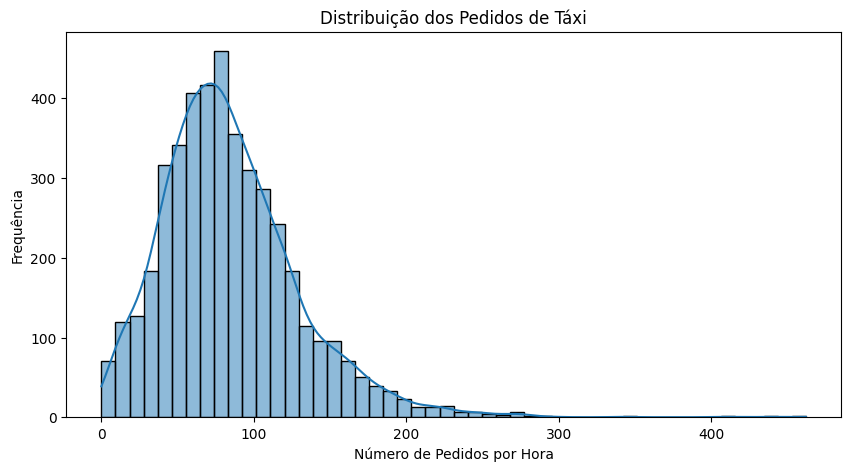

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df['num_orders'], bins=50, kde=True)
plt.title("Distribuição dos Pedidos de Táxi")
plt.xlabel("Número de Pedidos por Hora")
plt.ylabel("Frequência")
plt.show()

O método describe e o gráfico que gfoi gerado já nos revela insights interessantes. Primeiro, a média dos pedidos é de 84.42, mas o desvio padrão de 45 é bem alto. A nossa mediana é de 78, o que indica que outliers (ou a quantidade elevada de pedidos nos horários de pico) estão puxando a média para cima. percebemos uma destribuição assimétrica, que é confirmada pelo histpgrama. Ele ainda nos entrega uma cauda longa para a direita, mostrando que existem momentos em que temos mais de 300 e até 400 pedidos, valores bem distantes dos valores médios. Vamos fazer um novo gráfico para entender a demanda ao longo do tempo. 

### Verificando a demanda ao longo do tempo

#### Gráfico de meses

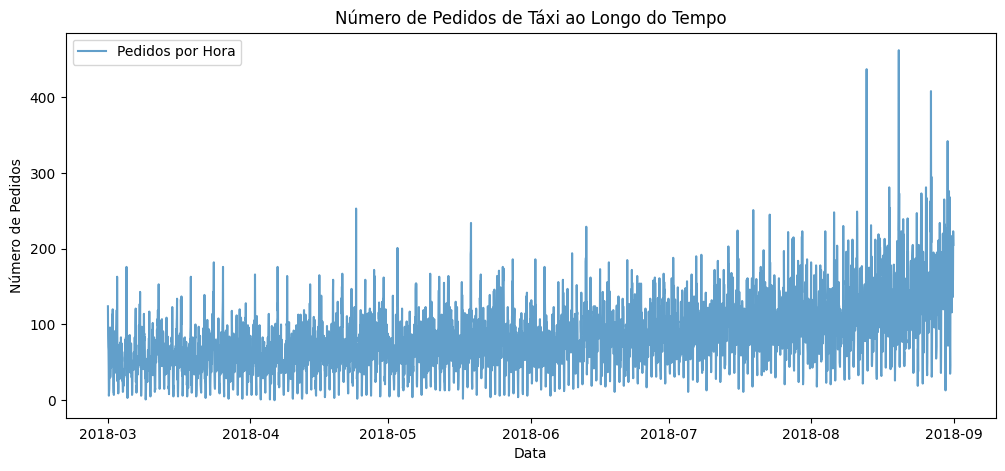

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['num_orders'], label='Pedidos por Hora', alpha=0.7)
plt.legend()
plt.title("Número de Pedidos de Táxi ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Número de Pedidos")
plt.show()

Neste primeiro gráfico, estamos trabalhando com períodos de meses. nele, percebemos um leve aumento nos pedidos conforme o ano avança, mas é difícil tirar qualquer conclusão mais relevante. Vamos trabalhar com gráficos semanais e por hora.

#### Gráfico de Dias da Semana

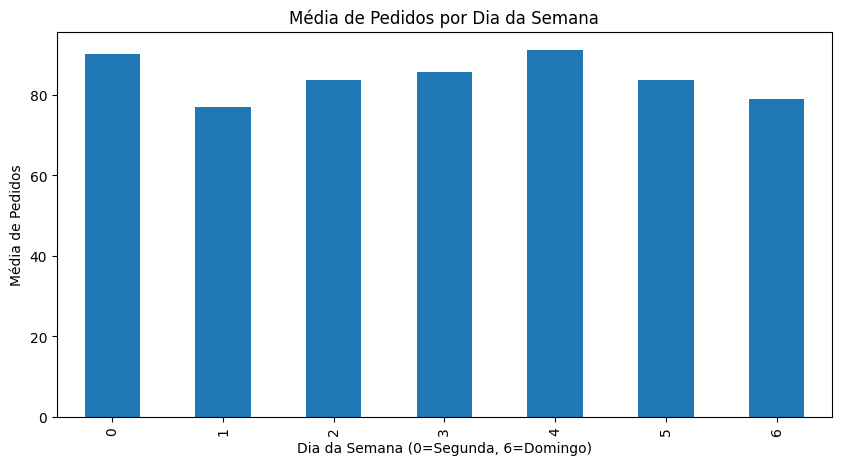

In [10]:
plt.figure(figsize=(10,5))
df.groupby(df.index.dayofweek)['num_orders'].mean().plot(kind='bar')
plt.title("Média de Pedidos por Dia da Semana")
plt.xlabel("Dia da Semana (0=Segunda, 6=Domingo)")
plt.ylabel("Média de Pedidos")
plt.show()

Eu esperava que o gráfico apontasse diferenças maiores de um dia para o outro, principalmente dos dias de semana para os finais de semana. Temos uma "esperada" queda nos sábados e domingos, que têm as menores médias, junto com a terça feira. Ainda assim, a quantidade de pedidos por dia mantém certa c0onstancia. Percebemos que segunda e sexta são os dias de maiores picos, indicando que trabalhadores podem viajar mais (ir e voltar) baseado na rotina de trabalho semanal e descanso aos finais de semana. 

#### Gráfico de Horas

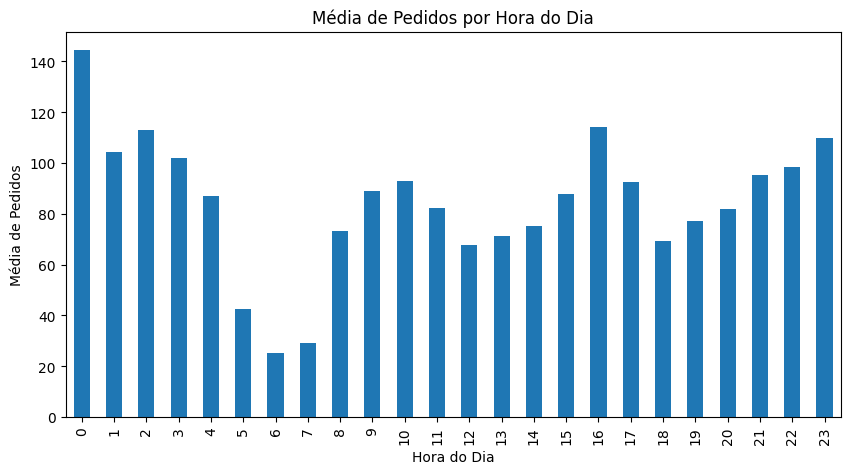

In [11]:
plt.figure(figsize=(10,5))
df.groupby(df.index.hour)['num_orders'].mean().plot(kind='bar')
plt.title("Média de Pedidos por Hora do Dia")
plt.xlabel("Hora do Dia")
plt.ylabel("Média de Pedidos")
plt.show()

Aqui, eu esperava que os picos fossem de acordo com as horas de rush mais tradicionais, mas essa ideia cai por terra com esse gráfico. Nosso maior pico é a meia noite, cai durante a madrugada e atinge o mínimo absoluto por volta de 6h e 7h. Considerando que esse é um dos horários me maior movimentação de carros em uma cidade normal, faz sentido que as pessoasevitem pedir taxis do ou para o aeroporto nesses horários, visto que o transito pode levar à atrasos. A partir das 7h o volume de pedidos cresce consideravelmente, atingindo o segundo maior pico às 16h. Os horários de 23h e 02h também tem uma demanda mais alta do que a média. Pensando pelo comportamento humano, faz sentido que as pessoas evitem pedir caronas à parentes e amigos, ou evitem dirigir elas mesmas nos hor´rios da madrugada, o que pode ajudar a entender o porque os taxis, especificamente, são mais requisitados nesses horários "alternativos".

### Adicionando Features de Calendário

Aqui, vamos adicionar novas colunas nosso dataframe, criando features de calendário que facilitem o trabalho dos nossos modelos na hora de identificar as tend~encias e os padrões que eles usarão para a previsão.

In [12]:

df['hour'] = df.index.hour  # Hora do dia (0 a 23)
df['dayofweek'] = df.index.dayofweek  # Dia da semana (0=Segunda, 6=Domingo)
df['month'] = df.index.month  # Mês do ano (1 a 12)

# Criando um indicador de fim de semana (1 = sábado/domingo, 0 = dias úteis)
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Criando categorias de períodos do dia
def get_time_of_day(hour):
    if hour < 6:
        return 'Madrugada'
    elif hour < 12:
        return 'Manhã'
    elif hour < 18:
        return 'Tarde'
    else:
        return 'Noite'

df['time_of_day'] = df['hour'].apply(get_time_of_day)

In [13]:
df.head()

,num_orders,hour,dayofweek,month,is_weekend,time_of_day
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,3,0,Madrugada
2018-03-01 01:00:00,85,1,3,3,0,Madrugada
2018-03-01 02:00:00,71,2,3,3,0,Madrugada
2018-03-01 03:00:00,66,3,3,3,0,Madrugada
2018-03-01 04:00:00,43,4,3,3,0,Madrugada


Deu certo, criamos nossas colunas. Agor, vamos adicionar a lag_features para que os modelos tenham os dados das horas anteriores para verificar a flutuação.

### Adicionando as Lag_Features

In [14]:
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)

In [15]:
df.head()

,num_orders,hour,dayofweek,month,is_weekend,time_of_day,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,3,3,0,Madrugada,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,0,Madrugada,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,0,Madrugada,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,3,0,Madrugada,71.0,85.0,124.0
2018-03-01 04:00:00,43,4,3,3,0,Madrugada,66.0,71.0,85.0


In [16]:
df.dropna(inplace=True)

In [17]:
df.head()

,num_orders,hour,dayofweek,month,is_weekend,time_of_day,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 03:00:00,66,3,3,3,0,Madrugada,71.0,85.0,124.0
2018-03-01 04:00:00,43,4,3,3,0,Madrugada,66.0,71.0,85.0
2018-03-01 05:00:00,6,5,3,3,0,Madrugada,43.0,66.0,71.0
2018-03-01 06:00:00,12,6,3,3,0,Manhã,6.0,43.0,66.0
2018-03-01 07:00:00,15,7,3,3,0,Manhã,12.0,6.0,43.0


Funcionou mais uma vez. Adicionamos as lag_features e excluímos as três primeiras linhas, porque para o início do dataframe, não temos valores anteriores, mas não podemos deixar como NaN. preferi excluir do que trocar por 0, ainda mais considerando que os primeiros horários englobavam a meia noite e as 2h da manhã, que, segundo nossa análise, são horários de pico e certamente não teriam zero chamadas. De qualquer forma, o impacto dessa decisão não é tão grande e qualquer uma das duas funcionaria. Vamos criar uma média móvel para o modelo.

### Criando uma Média Móvel

In [18]:
df['rolling_mean'] = df['num_orders'].shift(1).rolling(window=5).mean()

In [19]:
df.head(10)

,num_orders,hour,dayofweek,month,is_weekend,time_of_day,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 03:00:00,66,3,3,3,0,Madrugada,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,4,3,3,0,Madrugada,66.0,71.0,85.0,NaN
2018-03-01 05:00:00,6,5,3,3,0,Madrugada,43.0,66.0,71.0,NaN
2018-03-01 06:00:00,12,6,3,3,0,Manhã,6.0,43.0,66.0,NaN
2018-03-01 07:00:00,15,7,3,3,0,Manhã,12.0,6.0,43.0,NaN
2018-03-01 08:00:00,34,8,3,3,0,Manhã,15.0,12.0,6.0,28.4
2018-03-01 09:00:00,69,9,3,3,0,Manhã,34.0,15.0,12.0,22.0
2018-03-01 10:00:00,64,10,3,3,0,Manhã,69.0,34.0,15.0,27.2
2018-03-01 11:00:00,96,11,3,3,0,Manhã,64.0,69.0,34.0,38.8


In [20]:
df.dropna(inplace=True)

In [21]:
df.head()

,num_orders,hour,dayofweek,month,is_weekend,time_of_day,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 08:00:00,34,8,3,3,0,Manhã,15.0,12.0,6.0,28.4
2018-03-01 09:00:00,69,9,3,3,0,Manhã,34.0,15.0,12.0,22.0
2018-03-01 10:00:00,64,10,3,3,0,Manhã,69.0,34.0,15.0,27.2
2018-03-01 11:00:00,96,11,3,3,0,Manhã,64.0,69.0,34.0,38.8
2018-03-01 12:00:00,30,12,3,3,0,Tarde,96.0,64.0,69.0,55.6


Seguindo a mesma lógica das Lag_features, excluímos as primeiras linhas, que apresentavam valores ausentes. Com a média móvel, suavizamos os picos, o que é importante para um conjunto de dados com flutuação como o nosso.

### Gráficos de Tendência, Sazonalidade e Ruído

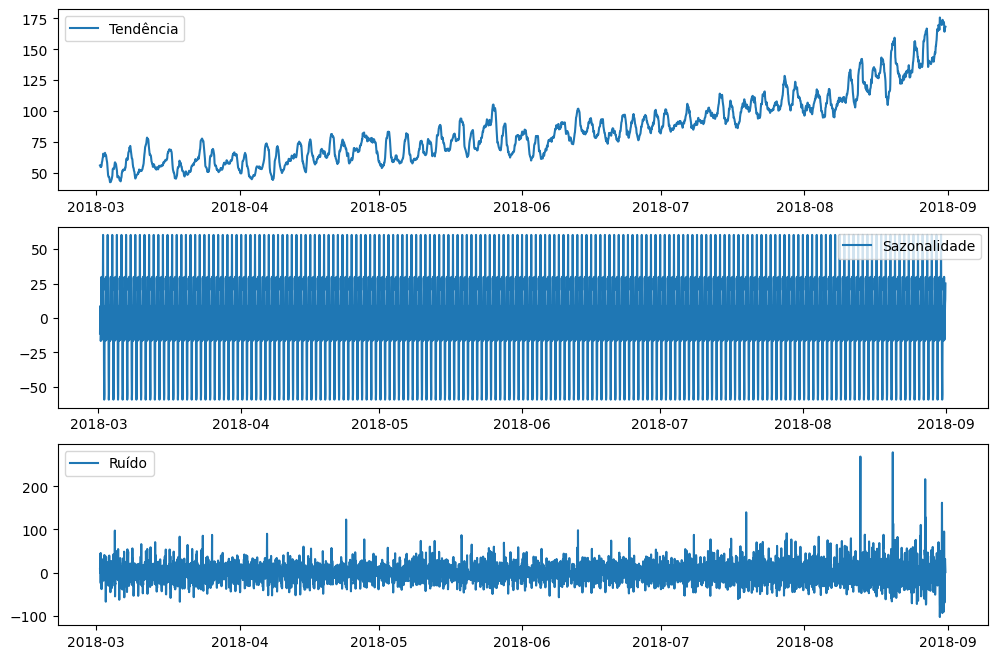

In [22]:
decomposition = seasonal_decompose(df['num_orders'], model='additive', period=24)

plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(decomposition.trend, label="Tendência")
plt.legend()

plt.subplot(3,1,2)
plt.plot(decomposition.seasonal, label="Sazonalidade")
plt.legend()

plt.subplot(3,1,3)
plt.plot(decomposition.resid, label="Ruído")
plt.legend()

plt.show()

Dos três gráficos, dois já nos dão, logo de cara, insights interessantes. O gráico de tendência clarifica algo que já havíamos percebido no gráfico de pedidos ao longo dos meses: há uma tendência de crescimento no número de pedidos conforme o ano avança. O gráfico de ruído mostra uma distribuição equilibrada, mas temos alguns picos a partir do mês de agosto, que podem ser explicados por qualquer evento atípico, mas que podem dificultar o trabalho do modelo nessa parte da previsão. O gráfico de sazonalidade ao decorrer dos meses nos dificulta a avaliação, então, é necessário fazer um novo gráfico de saznalidade. Vamos verificar apenas os primeiros 48 registros.

<div class="alert alert-block alert-warning">
<b>Comentário: </b> <a class="tocSkip"></a>

Os dados temporais foram lidos com sucesso. Sugestão de análise: 

- Verificar se os dados apresentam crescimento monotônico. 
    
```python
df.num_orders.is_monotonic_increasing
```
Saiba mais em: https://pandas.pydata.org/docs/reference/api/pandas.Series.is_monotonic_increasing.html
</div>

#### Novo gráfico de sazonalidade

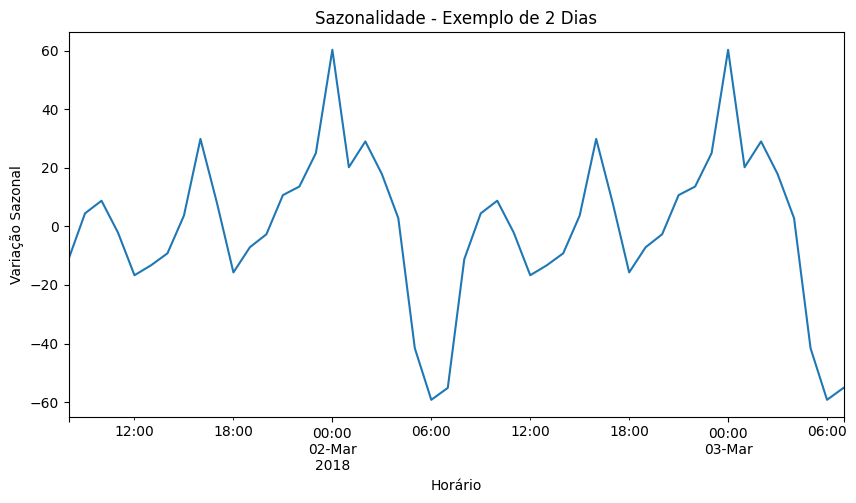

In [23]:
plt.figure(figsize=(10,5))
decomposition.seasonal[:48].plot()
plt.title("Sazonalidade - Exemplo de 2 Dias")
plt.xlabel("Horário")
plt.ylabel("Variação Sazonal")
plt.show()

Agora sim, enxergamos as coisas de forma mais clara. Essa sazonalidade reforça os picos de meia noite e as quedas abruptas de 06h. Está claro que a sazonalidade vai ser importante para o modelo fazer suas previsões. Podemos partir para a etapa de treinamento.

## Treinamento

In [43]:
features = df.drop(columns=['num_orders'])
target = df['num_orders']

In [44]:
features = pd.get_dummies(features, columns=['time_of_day'], drop_first=True)

In [45]:
train_size = int(len(features) * 0.9)

features_train, features_test = features.iloc[:train_size], features.iloc[train_size:]
target_train, target_test = target.iloc[:train_size], target.iloc[train_size:]

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Divisão dos dados para treino realizada com sucesso. 

Dica: também era possível utilizar o argumeno `shuffle=False` para fazer o split sequencial e não embaralhar os dados entre os conjuntos de treino e teste. 

    
Existem outras opções de implementações também para fazer essa divisão, segue como referêcia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

</div>

Separar manualmente usando o iloc, trocar a validação cruzada pelo TimeSeriesSplit e trabalar com parâmetros mais abrangentes para todos os modelos

In [46]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

Até aqui, adicionamos um one-hot encoding para evitar problemas com os dados do tipo object que nós mesmos havíamos criado com a coluna time_of_day. Então, dividimos e escalamos os dados. Agora, tudo está pronto para iniciarmos o treinamento.

### Floresta Aleatória

In [47]:
rf_model = RandomForestRegressor(random_state=12345, n_estimators=100)
rf_model.fit(features_train_scaled, target_train)

predictions_rf = rf_model.predict(features_test_scaled)

rmse_rf = np.sqrt(mean_squared_error(target_test, predictions_rf))

print(f"RMSE da Random Forest: {rmse_rf:.2f}")

RMSE da Random Forest: 47.66


#### Procurando os melhores hiperparâmetros e treinando a Floresta

In [48]:
param_grid_rf = {
    'n_estimators': [100, 150, 200, 250, 300],  
    'max_depth': [3, 5, 10, 15, 20, 25, 30],  
    'min_samples_split': [5, 10, 15]  
}

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

rf_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2
)

rf_search.fit(features_train_scaled, target_train)

best_rf = rf_search.best_estimator_

predictions_rf_opt = best_rf.predict(features_test_scaled)

rmse_rf_opt = np.sqrt(mean_squared_error(target_test, predictions_rf_opt))

print(f"Melhores Hiperparâmetros da Random Forest: {rf_search.best_params_}")
print(f"RMSE da Random Forest Otimizada: {rmse_rf_opt:.2f}")

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=150; total time=   0.2s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=150; total time=   0.4s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END .max_depth=3, min_samples_split=5, n_

[CV] END max_depth=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_split=10, n_estimators=150; total time=   0.2s
[CV] END max_depth=5, min_samples_split=10, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_split=10, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_split=10, n_estimators=150; total time=   0.5s
[CV] END max_depth=5, min_samples_split=10, n_estimators=150; total time=   0.6s
[CV] END max_depth=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, min_sa

[CV] END max_depth=10, min_samples_split=15, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_split=15, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_split=15, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_split=15, n_estimators=150; total time=   0.2s
[CV] END max_depth=10, min_samples_split=15, n_estimators=150; total time=   0.4s
[CV] END max_depth=10, min_samples_split=15, n_estimators=150; total time=   0.6s
[CV] END max_depth=10, min_samples_split=15, n_estimators=150; total time=   0.7s
[CV] END max_depth=10, min_samples_split=15, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=15, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_split=15, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_split=15, n_estimators=200; total time=   1.0s
[CV] END max_dep

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=   0.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=   1.0s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=   1.2s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END max_depth=20, min_s

[CV] END max_depth=25, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=25, min_samples_split=10, n_estimators=150; total time=   0.2s
[CV] END max_depth=25, min_samples_split=10, n_estimators=150; total time=   0.4s
[CV] END max_depth=25, min_samples_split=10, n_estimators=150; total time=   0.7s
[CV] END max_depth=25, min_samples_split=10, n_estimators=150; total time=   0.9s
[CV] END max_depth=25, min_samples_split=10, n_estimators=150; total time=   1.1s
[CV] END max_depth=25, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=25, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=25, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END max_depth=25, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=25, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END max_depth=25, min_samples_split=10, n_estimators=250; total time=   0.4s
[CV] END max_dep

[CV] END max_depth=30, min_samples_split=15, n_estimators=150; total time=   0.2s
[CV] END max_depth=30, min_samples_split=15, n_estimators=150; total time=   0.4s
[CV] END max_depth=30, min_samples_split=15, n_estimators=150; total time=   0.6s
[CV] END max_depth=30, min_samples_split=15, n_estimators=150; total time=   0.8s
[CV] END max_depth=30, min_samples_split=15, n_estimators=150; total time=   1.1s
[CV] END max_depth=30, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, min_samples_split=15, n_estimators=200; total time=   0.6s
[CV] END max_depth=30, min_samples_split=15, n_estimators=200; total time=   0.8s
[CV] END max_depth=30, min_samples_split=15, n_estimators=200; total time=   1.1s
[CV] END max_depth=30, min_samples_split=15, n_estimators=200; total time=   1.4s
[CV] END max_depth=30, min_samples_split=15, n_estimators=250; total time=   0.4s
[CV] END max_depth=30, min_samples_split=15, n_estimators=250; total time=   0.7s
[CV] END max_dep

A nossa floresta, com todas as alterações que fizemos no dataframe, buscando melhorar o desempenho, já havia atingido um resultado superior ao pedido pelo projeto. Adicionei o Gridsearch para procurar por parâmtros. Deixei o gridsearch trabalhar com um escopo grande de hiperparâmetros, mas tudo que ele conseguiu foi piorar um pouco o resultado. De qualquer forma, os dois estão aprovados. Não há mais nada para alterar aqui. Vamos verificar os outros modelos.

### Catboost

In [57]:
cat_model = CatBoostRegressor(random_seed=12345, iterations=500, depth=6, learning_rate=0.1, verbose=100)
cat_model.fit(features_train_scaled, target_train, verbose=100)

predictions_cat = cat_model.predict(features_test_scaled)

rmse_cat = np.sqrt(mean_squared_error(target_test, predictions_cat))

print(f"RMSE do CatBoost no conjunto de TESTE: {rmse_cat:.2f}")

0:	learn: 36.8213467	total: 1.69ms	remaining: 843ms
100:	learn: 20.3391790	total: 103ms	remaining: 407ms
200:	learn: 17.9820812	total: 209ms	remaining: 312ms
300:	learn: 16.4669226	total: 312ms	remaining: 206ms
400:	learn: 15.4054528	total: 415ms	remaining: 103ms
499:	learn: 14.6179396	total: 516ms	remaining: 0us
RMSE do CatBoost no conjunto de TESTE: 49.90


#### Procurando os melhores hiperparâmetros para o Catboost

In [55]:
"""param_grid_cat = {
    'iterations': [500, 1000, 1500, 2000],  
    'depth': [4, 6, 8, 10],  
    'learning_rate': [0.01, 0.03, 0.1, 0.2],  
    'l2_leaf_reg': [1, 3, 5, 10]  
}

cat_model = CatBoostRegressor(random_seed=12345, verbose=0)

cat_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cat,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2
)

cat_search.fit(features_train_scaled, target_train)

best_cat = cat_search.best_estimator_

predictions_cat_opt = best_cat.predict(features_test_scaled)

rmse_cat_opt = np.sqrt(mean_squared_error(target_test, predictions_cat_opt))

print(f"Melhores Hiperparâmetros do CatBoost: {cat_search.best_params_}")
print(f"RMSE do CatBoost Otimizado: {rmse_cat_opt:.2f}")"""

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.01; total time=   0.2s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.01; total time=   0.3s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.03; total time=   0.2s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.03; total time=   0.3s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.03; total time=   0.3s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.03; total time=   0.4s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learning_rate=0.03; total time=   0.4s
[CV] END depth=4, iterations=500, l2_leaf_reg=1, learnin

[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   0.6s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time=   0.7s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.2; total time=   0.4s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.2; total time=   0.5s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.2; total time=   0.5s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.2; total time=   0.6s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.2; total time=   0.8s
[CV] END depth=4, iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   0.4s
[CV] END depth=4, iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   0.5s
[CV] END depth=4, iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   0.6s
[CV] END depth=4, iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   0.6s
[CV] END depth=4, iterations

[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.03; total time=   0.6s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.03; total time=   0.8s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.03; total time=   0.8s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.03; total time=   0.9s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1; total time=   0.6s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1; total time=   0.6s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1; total time=   0.7s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1; total time=   0.8s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.1; total time=   0.9s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.2; total time=   0.6s
[CV] END depth=4, iterations=1500, l2_leaf_reg=3, learning_rate=0.2; total time=   0.7s
[CV] END depth=4, iterations

[CV] END depth=4, iterations=2000, l2_leaf_reg=3, learning_rate=0.2; total time=   1.2s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.01; total time=   0.7s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.01; total time=   0.8s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.01; total time=   0.9s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.01; total time=   1.1s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.01; total time=   1.2s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.03; total time=   0.7s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.03; total time=   0.8s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.03; total time=   1.1s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.03; total time=   1.2s
[CV] END depth=4, iterations=2000, l2_leaf_reg=5, learning_rate=0.03; total time=   1.2s
[CV] END depth=4, iter

[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=   0.5s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=   0.5s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=   0.6s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.2; total time=   0.4s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.2; total time=   0.4s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.2; total time=   0.7s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.2; total time=   0.6s
[CV] END depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.2; total time=   0.6s
[CV] END depth=6, iterations=500, l2_leaf_reg=10, learning_rate=0.01; total time=   0.4s
[CV] END depth=6, iterations=500, l2_leaf_reg=10, learning_rate=0.01; total time=   0.4s
[CV] END depth=6, iterations=500, l2_leaf_reg=10, learning_rate=0.01; total time=   0.5s
[CV] END depth=6, iterations=500, l2_

[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.03; total time=   0.7s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.03; total time=   0.8s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.03; total time=   0.9s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.03; total time=   1.0s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.03; total time=   1.1s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   0.7s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   0.8s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   0.9s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   1.0s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.1; total time=   1.1s
[CV] END depth=6, iterations=1000, l2_leaf_reg=10, learning_rate=0.2; total time=   0.7s
[CV] END depth=6

[CV] END depth=6, iterations=1500, l2_leaf_reg=10, learning_rate=0.2; total time=   1.4s
[CV] END depth=6, iterations=1500, l2_leaf_reg=10, learning_rate=0.2; total time=   1.6s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.3s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.5s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.7s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.01; total time=   1.9s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.01; total time=   2.0s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.03; total time=   1.3s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.03; total time=   1.6s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.03; total time=   1.8s
[CV] END depth=6, iterations=2000, l2_leaf_reg=1, learning_rate=0.03; total time=   1.9s
[CV] END depth=6, ite

[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.1; total time=   1.0s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.1; total time=   1.1s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.1; total time=   1.2s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.1; total time=   1.3s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.2; total time=   0.9s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.2; total time=   1.1s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.2; total time=   1.1s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.2; total time=   1.2s
[CV] END depth=8, iterations=500, l2_leaf_reg=1, learning_rate=0.2; total time=   1.3s
[CV] END depth=8, iterations=500, l2_leaf_reg=3, learning_rate=0.01; total time=   0.9s
[CV] END depth=8, iterations=500, l2_leaf_reg=3, learning_rate=0.01; total time=   1.0s
[CV] END depth=8, iterations=500, l2_leaf

[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=   1.7s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=   1.9s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=   2.0s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=   2.2s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.03; total time=   2.4s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.7s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   1.9s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   2.1s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   2.2s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=   2.4s
[CV] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=   1.7s
[CV] END depth=8, iteration

[CV] END depth=8, iterations=1500, l2_leaf_reg=3, learning_rate=0.2; total time=   3.3s
[CV] END depth=8, iterations=1500, l2_leaf_reg=3, learning_rate=0.2; total time=   3.6s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.01; total time=   2.4s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.01; total time=   2.8s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.01; total time=   3.0s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.01; total time=   3.3s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.01; total time=   3.5s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.03; total time=   2.4s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.03; total time=   2.9s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.03; total time=   3.0s
[CV] END depth=8, iterations=1500, l2_leaf_reg=5, learning_rate=0.03; total time=   3.3s
[CV] END depth=8, itera

[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.1; total time=   3.7s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.1; total time=   4.1s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.1; total time=   4.3s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.1; total time=   4.6s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time=   3.2s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time=   3.8s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time=   4.0s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time=   4.4s
[CV] END depth=8, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time=   4.7s
[CV] END depth=8, iterations=2000, l2_leaf_reg=10, learning_rate=0.01; total time=   3.2s
[CV] END depth=8, iterations=2000, l2_leaf_reg=10, learning_rate=0.01; total time=   3.7s
[CV] END depth=8, iterations

[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.01; total time=   3.3s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.03; total time=   2.3s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.03; total time=   2.8s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.03; total time=   2.8s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.03; total time=   3.1s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.03; total time=   3.4s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.1; total time=   2.5s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.1; total time=   2.9s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.1; total time=   3.0s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.1; total time=   3.3s
[CV] END depth=10, iterations=500, l2_leaf_reg=10, learning_rate=0.1; total time=   3.4s
[CV] END depth=

[CV] END depth=10, iterations=1000, l2_leaf_reg=10, learning_rate=0.2; total time=   5.7s
[CV] END depth=10, iterations=1000, l2_leaf_reg=10, learning_rate=0.2; total time=   6.0s
[CV] END depth=10, iterations=1000, l2_leaf_reg=10, learning_rate=0.2; total time=   6.3s
[CV] END depth=10, iterations=1000, l2_leaf_reg=10, learning_rate=0.2; total time=   6.8s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.01; total time=   7.1s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.01; total time=   8.5s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.01; total time=   8.8s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.01; total time=   9.5s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.01; total time=  10.1s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.03; total time=   7.2s
[CV] END depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.03; total time=   8.4s
[CV] END d

[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.03; total time=  13.1s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.03; total time=  13.8s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time=   9.8s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time=  11.3s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time=  11.8s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time=  12.9s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.1; total time=  13.4s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.2; total time=   9.7s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.2; total time=  11.4s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.2; total time=  11.9s
[CV] END depth=10, iterations=2000, l2_leaf_reg=1, learning_rate=0.2; total time=  12.7s
[CV] END depth=10, 

Aqui, repetimos o processo. Treinamos o cat_bost com os valores padrão de hiperparâmetro e usamos o gridsearch para procurar os melhores hiperparâmetros pra ele. Quando fiz o código, não pedi o tempo de execução da célula, mas ela levou mais de uma hora para finalizar a procura. Um tempo muito maior do que todos os outros para entregar resultados que não são bons o suficiente. O Catboost está reprovado.

<div class="alert alert-block alert-success">

<b>Comentário: </b> <a class="tocSkip"></a>
    
Bom trabalho utilizando o GridSearch! Realmente, o tempo de processamento pode ser bem longo haha.

Aqui estão algumas dicas para rodar mais rápido:

Troque o GridSearch pelo RandomizedSearchCV: Se você está usando o GridSearch para explorar os hiperparâmetros, considere utilizar o RandomizedSearchCV. Ele não busca por todas as combinações possíveis, mas amostra aleatoriamente o espaço de parâmetros, o que muitas vezes encontra bons resultados muito mais rápido, especialmente quando a grade de parâmetros é grande.

Paralelize a busca: Configurando o parâmetro n_jobs, você pode paralelizar a busca utilizando múltiplos CPUs. Defina n_jobs=-1 para usar todos os núcleos disponíveis.

### Regressão Linear

In [64]:
lr_model = LinearRegression()
lr_model.fit(features_train_scaled, target_train)

predictions_lr = lr_model.predict(features_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(target_test, predictions_lr))

print(f"RMSE da Regressão Linear no conjunto de TESTE: {rmse_lr:.2f}")

RMSE da Regressão Linear no conjunto de TESTE: 55.68


#### Procurando os Melhores Parâmetros para a Regressão

In [62]:
lr_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()

# Definir os hiperparâmetros para GridSearch
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100]  # Regularização L2
}

param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100]  # Regularização L1
}

# Criar o GridSearchCV para cada modelo usando o tscv já definido
lr_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2
)

ridge_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_ridge,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2
)

lasso_search = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid_lasso,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2
)

# Treinar os modelos
lr_search.fit(features_train_scaled, target_train)
ridge_search.fit(features_train_scaled, target_train)
lasso_search.fit(features_train_scaled, target_train)

# Melhor modelo encontrado para cada tipo
best_lr = lr_search.best_estimator_
best_ridge = ridge_search.best_estimator_
best_lasso = lasso_search.best_estimator_

# Fazer previsões no conjunto de teste
predictions_lr_opt = best_lr.predict(features_test_scaled)
predictions_ridge_opt = best_ridge.predict(features_test_scaled)
predictions_lasso_opt = best_lasso.predict(features_test_scaled)

# Calcular RMSE no conjunto de teste
rmse_lr_opt = np.sqrt(mean_squared_error(target_test, predictions_lr_opt))
rmse_ridge_opt = np.sqrt(mean_squared_error(target_test, predictions_ridge_opt))
rmse_lasso_opt = np.sqrt(mean_squared_error(target_test, predictions_lasso_opt))

# Exibir os resultados
print(f"Melhores Hiperparâmetros da Regressão Linear: {lr_search.best_params_}")
print(f"RMSE da Regressão Linear Otimizada: {rmse_lr_opt:.2f}")

print(f"Melhores Hiperparâmetros da Ridge Regression: {ridge_search.best_params_}")
print(f"RMSE da Ridge Regression Otimizada: {rmse_ridge_opt:.2f}")

print(f"Melhores Hiperparâmetros da Lasso Regression: {lasso_search.best_params_}")
print(f"RMSE da Lasso Regression Otimizada: {rmse_lasso_opt:.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=False, positive=True; total time=   0.0s
[CV] END .................fit_intercept=False, po

Foram nossos piores modelos em RMSE. Estão longe dos 48 pedidos pelo projeto. As regressões estão reprovadas. Mas isso já é o suficiente para dar fim ao projeto. Temos nosso modelo que bate os valores que nos foram pedidos. Podemos seguir sem medo.

## Conclusão

Com isso, finalizamos mais um projeto. A etapa de preparação dos dados não teve nenhum segredo. Tivemos que mudar o tipo de dado da coluna de data e hora para datetime e deixá-la como index. Além disso, adicionamos diversas colunas com características que ajudaram nossos modelos em suas previsões. Na etapa de Análise Exploratória, focamos em tentar entender padrões e localizar alguns outliers que pudessem ajudar/prejudicar as previsões. Nesse ponto, tivemos algumas surpresas com os padrões dos pedidos, que fugiam um pouco do que eu imaginava. Adicionamos features de calendário, média móvel e tudo que os modelos precisariam para trabalhar com uma série temporal. 

Depois disso tudo, foi uma questão de treinar os modelos. Treinamos uma Floresta Aleatória, um Catboost e uma regressão, buscando o RMSE alvo inferior

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Muito boa conclusão fundamentada em dados da análise!

</div>

# Revisão da checklist

- [x]  O Jupyter Notebook está aberto.

- [ ]  O código está livre de erros
- [ ]  As células com o código foram organizadas em ordem de execução.
- [ ]  Os dados foram baixados e preparados

- [ ]  Os dados foram analisados
- [ ]  O modelo foi treinado e os hiperparâmetros foram selecionados
- [ ]  	
O modelo foi avaliado. Uma conclusão foi fornecida

- [ ] 
O REQM para o conjunto de teste não é maior que 48